-- Source Informations --
Total input particle: 3.33198e+21 part/s
Total input power: 421.701 kW


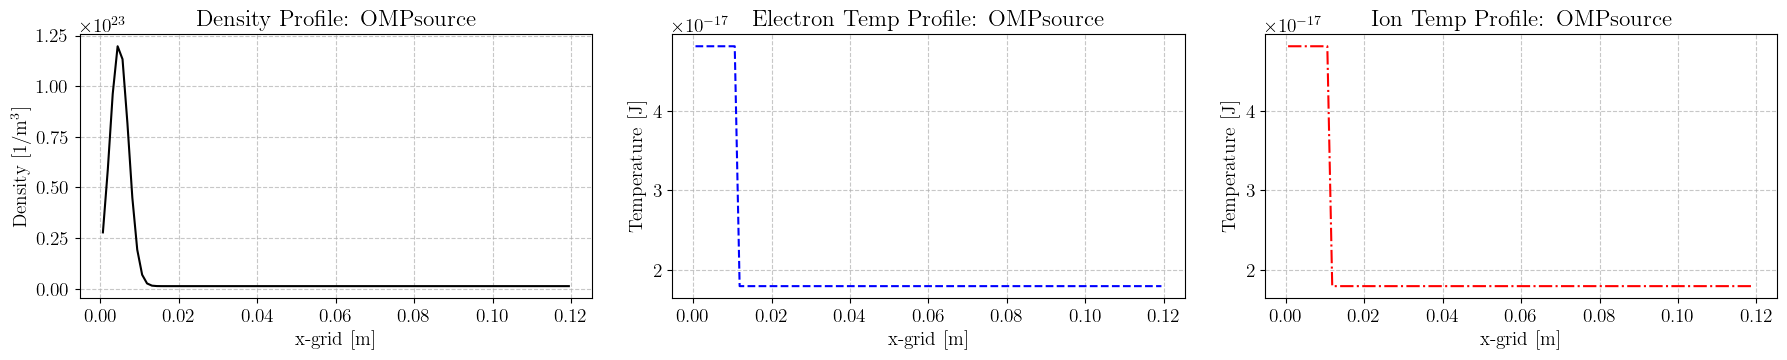

Time frames available from 0 to 231


In [ ]:
# First reset the pygkyl library
import sys
!rm -rf ~/personal_gkyl_scripts/pygkyl/pygkyl.egg-info
!rm -rf ~/personal_gkyl_scripts/pygkyl/build
!{sys.executable} -m pip install ~/personal_gkyl_scripts/pygkyl > ~/personal_gkyl_scripts/pygkyl/install.log

import numpy as np
import matplotlib.pyplot as plt
import os

# Configure plotting
plt.rcParams["figure.figsize"] = (6,4)

# Custom libraries and routines
from pygkyl import Simulation, Species, file_utils, Source

home_dir = os.path.expanduser("~")
repo_dir = home_dir+'/personal_gkyl_scripts/'
simdir = repo_dir+'sim_data_dir_example/3x2v_example/gk_tcv_posD_iwl_3x2v_electron_heating/'
fileprefix = 'gk_tcv_posD_iwl_3x2v_D02'
simulation = Simulation(dimensionality='3x2v')
simulation.set_phys_param(
    B_axis = 1.4,           # Magnetic field at magnetic axis [T]
    eps0 = 8.854e-12,       # Vacuum permittivity [F/m]
    eV = 1.602e-19,         # Elementary charge [C]
    mp = 1.673e-27,         # Proton mass [kg]
    me = 9.109e-31,         # Electron mass [kg]
)
def qprofile(R):
    a = [497.3420166252413, -1408.736172826569, 1331.4134861681464, -419.00692601227627]
    return a[0]*R**3 + a[1]*R**2 + a[2]*R + a[3]
simulation.set_geom_param(
    R_axis      = 0.8727315068,         # Magnetic axis major radius
    Z_axis      = 0.1414361745,         # Magnetic axis height
    R_LCFSmid   = 1.0968432365089495,   # Major radius of LCFS at the midplane
    a_shift     = 0.25,                 # Parameter in Shafranov shift
    kappa       = 1.5,                  # Elongation factor
    delta       = 0.3,                  # Triangularity factor
    qprofile    = qprofile,             # Safety factor
    x_LCFS      = 0.04,                 # position of the LCFS (= core domain width)
    x_out       = 0.08                  # SOL domain width
)
# Define the species
ion = Species(name='ion',
              m=2.01410177811*simulation.phys_param.mp, # Ion mass
              q=simulation.phys_param.eV,               # Ion charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
elc = Species(name='elc',
              m=simulation.phys_param.me, 
              q=-simulation.phys_param.eV, # Electron charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
# Add them to the simulation (we need to know this before setting up the data parameters)
simulation.add_species(ion)
simulation.add_species(elc)
# This call will set up the data structure of the simulation and set up a large dictionary 
# conaining the receipes of many post processing quantities, see simulation.data_param.info()
simulation.set_data_param( simdir = simdir, fileprefix = fileprefix, species = simulation.species)
# This is the first call that will load data. 
# If the paths are not set up correctly, the script will fail here.
simulation.geom_param.load_metric(simulation.data_param.fileprefix)
n_srcOMP=1.2e23
Te_srcOMP=3 * simulation.species['elc'].T0
Ti_srcOMP=3 * simulation.species['ion'].T0
sigma_srcOMP=0.02 * simulation.geom_param.Lx
x_srcOMP=2*sigma_srcOMP
floor_src=1e-2
def custom_density_src_profile(x,y,z):
    return n_srcOMP * (np.exp(-((x - x_srcOMP) ** 2) / (2.0 * sigma_srcOMP ** 2)) + floor_src)
def custom_temp_src_profile_elc(x, y = None, z = None):
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Te_srcOMP; fout[~mask] = Te_srcOMP * 3.0 / 8.0
    return fout  
def custom_temp_src_profile_ion( x, y = None, z = None):
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Ti_srcOMP; fout[~mask] = Ti_srcOMP * 3.0 / 8.0
    return fout   
OMPsource = Source(n_src=n_srcOMP,x_src=x_srcOMP,Te_src=Te_srcOMP,Ti_src=Ti_srcOMP,
                   sigma_src=sigma_srcOMP,floor_src=floor_src,
                   density_src_profile=custom_density_src_profile,
                   temp_src_profile_elc=custom_temp_src_profile_elc,
                   temp_src_profile_ion=custom_temp_src_profile_ion)
simulation.add_source('OMPsource',OMPsource)
simulation.source_info(type='profile', y_const=0, z_const=0)
# simulation.get_input_power(type='profile')
# simulation.get_input_particle(type='profile')
# simulation.OMPsources.plot(x_grid=simulation.geom_param.grids[0],y_const=0,z_const=0)
# simulation.plot_sources(0,0)
# simulation.normalize('t','mus') # time in micro-seconds
# simulation.normalize('x','minor radius') # radial coordinate normalized by the minor radius (rho=r/a)
# simulation.normalize('y','Larmor radius') # binormal in term of reference sound Larmor radius
# simulation.normalize('z','pi') # parallel angle devided by pi
# simulation.normalize('fluid velocities','thermal velocity') # fluid velocity moments are normalized by the thermal velocity
# simulation.normalize('temperatures','eV') # temperatures in electron Volt
# simulation.normalize('pressures','Pa') # pressures in Pascal
# simulation.normalize('energies','MJ') # energies in mega Joules

fieldname = fileprefix+'-field' #e.g. we check the electrostatic field files.
sim_frames = file_utils.find_available_frames(simulation,fieldname)
print("Time frames available from %g to %g"%(sim_frames[0],sim_frames[-1]))

In [4]:
from pygkyl import Frame
from pygkyl import phys_tools
Bmag_frame = Frame(simulation,'Bmag',0)
Bmag_frame.load()
Bmag_frame.slice_1D('x',[0.0,0.0])
Bfield = np.squeeze(Bmag_frame.values)

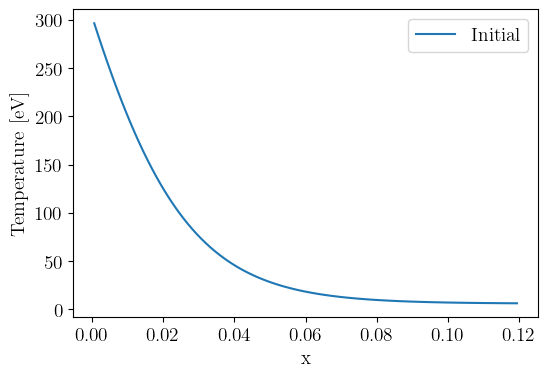

In [5]:
def temp_initial_profile(x):
    return 6.*ion.T0*(0.7*(1.+np.tanh(3.*(-.1-10.*x)))+0.01)
# plot temperature profile
x = simulation.geom_param.grids[0]
plt.plot(x,temp_initial_profile(x)/simulation.phys_param.eV,label='Initial')
plt.xlabel('x')
plt.ylabel('Temperature [eV]')
plt.legend()
plt.show()

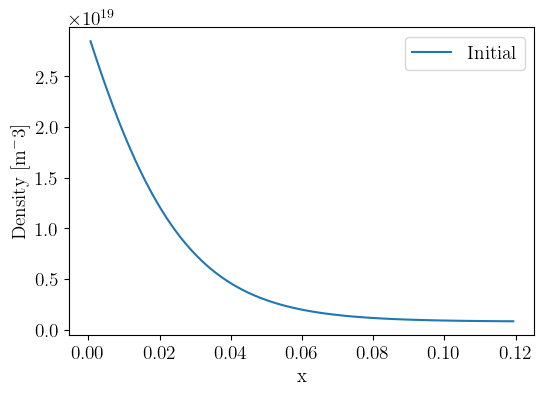

In [6]:
# same for density profile
def density_initial_profile(x):
    return 4*2e19*(0.5*(1.+np.tanh(3.*(-.1-10.*x)))+0.01)
# plot density profile
plt.plot(x,density_initial_profile(x),label='Initial')
plt.xlabel('x')
plt.ylabel(r'Density [m$^-3$]')
plt.legend()
plt.show()

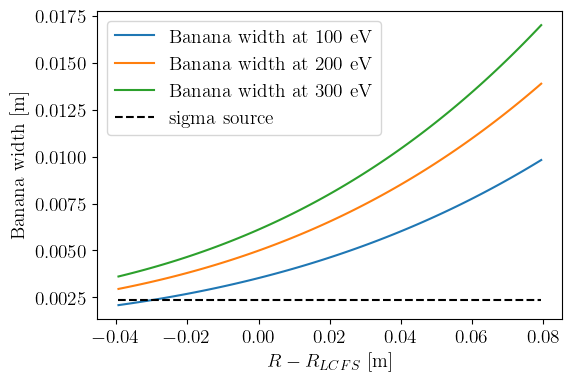

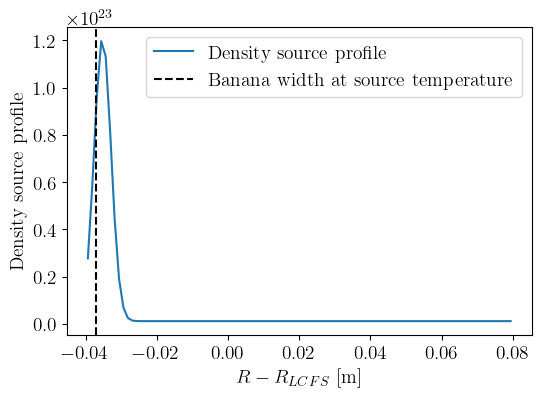

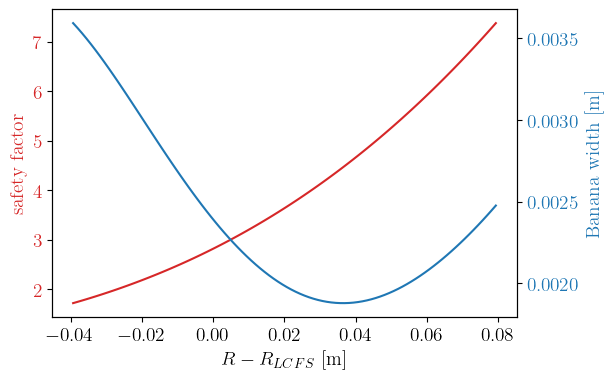

In [7]:

# Compute the banana width in function of the radial position
x = simulation.geom_param.grids[0]
Rx = simulation.geom_param.R_x(x)
RmLCFS = Rx - simulation.geom_param.R_LCFSmid

temperature = temp_initial_profile(x)
qfactor = qprofile(Rx)

epsilon = simulation.geom_param.get_epsilon()
bw = phys_tools.banana_width(ion.q, ion.m, temperature, Bfield, qfactor, epsilon)

bw100eV = phys_tools.banana_width(ion.q, ion.m, 100*simulation.phys_param.eV, Bfield, qfactor, epsilon)
bw200eV = phys_tools.banana_width(ion.q, ion.m, 200*simulation.phys_param.eV, Bfield, qfactor, epsilon)
bw300eV = phys_tools.banana_width(ion.q, ion.m, 300*simulation.phys_param.eV, Bfield, qfactor, epsilon)

# plot banana width
fig, ax1 = plt.subplots()
#ax1.plot(RmLCFS, bw, label='Banana width initial condition')
ax1.plot(RmLCFS, bw100eV, label='Banana width at 100 eV')
ax1.plot(RmLCFS, bw200eV, label='Banana width at 200 eV')
ax1.plot(RmLCFS, bw300eV, label='Banana width at 300 eV')
ax1.plot(RmLCFS, np.ones_like(RmLCFS)*sigma_srcOMP, '--k', label='sigma source')
ax1.set_xlabel(r'$R-R_{LCFS}$ [m]')
ax1.set_ylabel('Banana width [m]')
plt.legend()
plt.show()

# plot density source and mark the banana width at that temperature
bwsrc = phys_tools.banana_width(ion.q, ion.m, 200*simulation.phys_param.eV, Bfield[0], qfactor[0], epsilon)
fig, ax = plt.subplots()
ax.plot(RmLCFS, custom_density_src_profile(x,0,0), label='Density source profile')
ax.axvline(x=bwsrc - simulation.geom_param.x_LCFS, color='k', linestyle='--', label='Banana width at source temperature')
ax.set_xlabel(r'$R-R_{LCFS}$ [m]')
ax.set_ylabel('Density source profile')
plt.legend()
plt.show()

# plot qfactor
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('safety factor', color=color)
ax1.plot(RmLCFS, qfactor, color=color)
ax1.tick_params(axis='y', labelcolor=color)
# plot banana width
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Banana width [m]', color=color)
ax1.set_xlabel(r'$R-R_{LCFS}$ [m]')
ax2.plot(RmLCFS, bw, color=color)
ax2.tick_params(axis='y', labelcolor=color)



In [8]:
# Here we compute the integral using the first DG coeff and a Riemann sum.
import postgkyl as pg
# load the M2e diag of the source
data = pg.GData(simdir+fileprefix+'-elc_source_M2_0.gkyl')
# get the coefficient of the expansion
vth2_e = data.get_values()
# take only the first coefficient
vth2_e = vth2_e[:,:,0]/2
# load the M2i diag of the source
data = pg.GData(simdir+fileprefix+'-ion_source_M2_0.gkyl')
# get the coefficient of the expansion
vth2_i = data.get_values()
# take only the first coefficient
vth2_i = vth2_i[:,:,0]/2
# do the same for the Jacobian
data = pg.GData(simdir+fileprefix+'-jacobgeo.gkyl')
Jacobian = data.get_values()[:,:,0]/2

# interpolate the data to the grid
grid = data.get_grid()
# get the values of the grid
x = grid[0][:-1]
z = grid[1][:-1]
# build the integrant
integrant = (0.5*elc.m*vth2_e + 0.5*ion.m*vth2_i)*Jacobian
# integrate the integrant
integral = (x[1]-x[0])*(z[1]-z[0])*np.sum(integrant)
print('Lineic power with DG coeff 0 :',integral/1e3)
Ly = 0.33624
print('Total power: ',Ly*integral/1e3,'kW')

Lineic power with DG coeff 0 : 117.69441129877906
Total power:  39.57356885510147 kW


In [9]:
# Here we compute the integral using the Frame class and the integral surf.
from pygkyl import Frame
from pygkyl import math_tools as mt
M2e = Frame(simulation,'M2e_src',0)
M2e.load()
integrant = 0.5*elc.m*M2e.values*simulation.geom_param.Jacobian

M2i = Frame(simulation,'M2i_src',0)
M2i.load()
integrant += 0.5*ion.m*M2i.values*simulation.geom_param.Jacobian

# integrate
integral = mt.integral_surf(simulation.geom_param.grids[0],simulation.geom_param.grids[2],integrant[:,0,:])
print('Lineic power: ',integral/1e3,'kW/m')
Ly = 0.33624
print('Total power: ',Ly*integral/1e3,'kW')

Lineic power:  1795.7540925422643 kW/m
Total power:  603.804356076411 kW


In [10]:
# Here we compute the integral using the Frame class and the integral surf.
from pygkyl import Frame
from pygkyl import math_tools as mt
M2e = Frame(simulation,'M2e_src',0)
M2e.load()
M2e_int = M2e.compute_surface_integral('xz')
integral = 0.5*elc.m*M2e_int

M2i = Frame(simulation,'M2i_src',0)
M2i.load()
M2i_int = M2i.compute_surface_integral('xz')
integral += 0.5*ion.m*M2i_int

print('Lineic power: ',integral/1e3,'kW/m')
Ly = 0.33624
print('Total power: ',Ly*integral/1e3,'kW')

Lineic power:  1795.754092542264 kW/m
Total power:  603.8043560764108 kW


In [11]:
lambda_source = 0.0011
x_source = 0.1534
Lz = 2*np.pi
z_source = -Lz / 4.0
S0 = 24.08e22
source_floor = 0.01 * S0
eV = 1.602e-19  # Elementary charge constant
def custom_density_src_profile(x,y,z):
    z_condition = np.abs(z - z_source) < Lz / 8.0
    result = np.full_like(x, source_floor)  # Initialize result with source_floor
    result[z_condition] = np.maximum(source_floor,
        S0 * np.exp(-(x[z_condition] - x_source) ** 2 / (2 * lambda_source ** 2)))
    return result
def custom_temp_src_profile_elc(x, y = None, z = None):
    x_condition = x < (x_source + 3 * lambda_source)
    z_condition = np.abs(z - z_source) < Lz / 8.0
    condition = x_condition & z_condition
    result = np.full_like(x, 1.920292202211762 * eV)  # Default value
    result[condition] = 40.0 * eV  # Update where the condition is met
    return result
def custom_temp_src_profile_ion( x, y = None, z = None):
    x_condition = x < (x_source + 3 * lambda_source)
    z_condition = np.abs(z - z_source) < Lz / 8.0
    condition = x_condition & z_condition
    result = np.full_like(x, 3.4565259639811785 * eV)  # Default value
    result[condition] = 72.0 * eV  # Update where the condition is met
    return result

from tools import math_tools as mt
[X,Y,Z] = mt.custom_meshgrid(simulation.geom_param.grids[0],simulation.geom_param.grids[1],simulation.geom_param.grids[2])

nsrc = custom_density_src_profile(X,Y,Z)
Tesrc = custom_temp_src_profile_elc(X,Y,Z)
Tisrc = custom_temp_src_profile_ion(X,Y,Z)
srcpow = 1.5 * nsrc * (Tesrc + Tisrc)
integrant = srcpow * simulation.geom_param.Jacobian
lin_pow = mt.integral_surf(simulation.geom_param.grids[0],simulation.geom_param.grids[2],integrant[:,0,:])
print('lineic power:',lin_pow/1e3,'kW/m')
Ly = 0.33624
print('Total power: ',Ly*lin_pow/1e3,'kW')

lineic power: 53.73891561982304 kW/m
Total power:  18.069172988009296 kW


In [12]:
from pygkyl import Frame
time = []
P_iw = []
P_ow = []
P_TSlo = []
P_TSup = []
P_limlo = []
P_limup = []
P_ylo   = []
P_yup   = []

for tf in sim_frames[::5]:
    # radial outer wall loss
    f_ = Frame(simulation,'ExB_hflux_x',tf=tf,load=True)
    flux_ = f_.compute_surface_integral(
        direction='yz',
        ccoord=f_.cells[0],
        int_bounds=['all','all'],
        integrant_filter='all'
        )
    P_ow.append(flux_)

    # limiter lower loss
    f_ = Frame(simulation,'ExB_hflux_z',tf=tf,load=True)
    flux_ = f_.compute_surface_integral(
        direction='xy', 
        ccoord=0,
        int_bounds=[[simulation.geom_param.x_LCFS,0.12],'all'],
        integrant_filter='all'
        )
    P_limlo.append(flux_)

    # limiter upper loss
    f_ = Frame(simulation,'ExB_hflux_z',tf=tf,load=True)
    flux_ = f_.compute_surface_integral(
        direction='xy',
        ccoord=f_.cells[2],
        int_bounds=[[simulation.geom_param.x_LCFS,0.12],'all'],
        integrant_filter='all'
        )
    P_limup.append(flux_)

    # save time
    time.append(f_.time)

KeyboardInterrupt: 

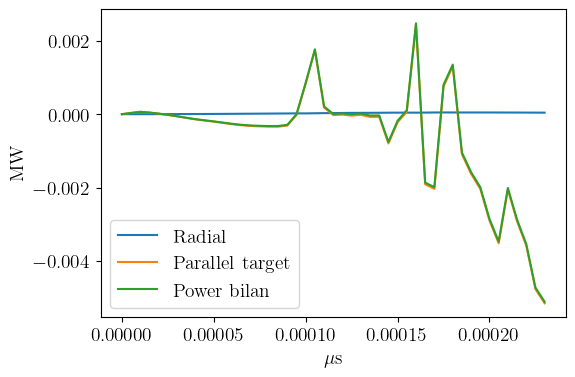

In [ ]:
units = 'MW'
if units == 'MW':
    scale = 1e6
P_x = np.array(P_ow)
P_y = np.array(P_limup) + np.array(P_limlo)
plt.plot(time, P_x/scale, label = 'Radial')
# plt.plot(time, Py_bilan, label = 'Binormal')
# plt.plot(time, Pz_core_bilan, label = 'Parallel core')
plt.plot(time, P_y/scale, label = 'Parallel target')
plt.plot(time, (P_x + P_y)/scale, label = 'Power bilan')
plt.ylabel(units)
plt.xlabel(r'$\mu$s')
plt.legend()
plt.show()

Text(0, 0.5, 'MJ')

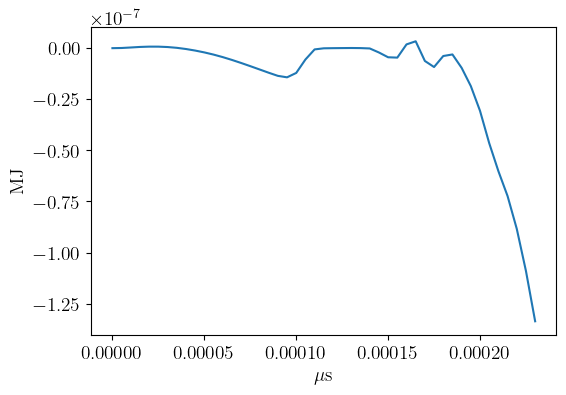

In [14]:
import scipy as scp
E_bilan = scp.integrate.cumtrapz((P_x + P_y)/1e6,x=time, initial=0)
plt.plot(time,E_bilan,label='Energy flux bilan')
plt.xlabel(r'$\mu$s')
plt.ylabel('MJ')

In [ ]:
from pygkyl import Frame
from pygkyl import math_tools
from scipy.interpolate import interp1d
f_ = Frame(simulation,'ne',tf=10)
f_.load()

#. Give human readable symboles for useful variables
Fxyz = f_.values

#. Load the new_grids (1 element less than nodes)
x    = f_.new_grids[0]; Nx = len(x)
y    = f_.new_grids[1]; Ny = len(y)
z    = f_.new_grids[2]; Nz = len(z)

# Densification factor and new number of points in z
Nfacz  = 1
Nzdens = Nfacz * Nz
# Create denser z grid
zdens = np.linspace(z[0], z[-1], Nzdens)
# Create an empty array for the interpolated data
Fxyz_dens = np.zeros((Nx, Ny, Nzdens))
# Interpolate over the z-axis for each (x, y) pair

for i in range(Nx):
    for j in range(Ny):
        # Define the 1D interpolation along the z-axis
        interp_func = interp1d(z, Fxyz[i, j, :], kind='linear', axis=-1, fill_value="extrapolate")
        # Interpolate to the new denser z grid
        Fxyz_dens[i, j, :] = interp_func(zdens)

[Xxyz, Yxyz, Zxyz] = math_tools.custom_meshgrid(x,y,zdens)

Ny   = len(y)
# y-y0 array (named u for shorter symbols)
u    = y - y[0]
Ly   = u[-1]
dy   = y[1] - y[0]

[Xxuz, Uxuz, Zxuz] = math_tools.custom_meshgrid(x,u,zdens)

#.Magnetic safety factor in the middle of the simulation box
qprofile = simulation.geom_param.qprofile
r_x      = simulation.geom_param.r_x
r0 = simulation.geom_param.r0
q0 = qprofile(r0)

xLCFS = simulation.geom_param.x_LCFS
ixLCFS = math_tools.closest_index(x,xLCFS)

#.Composed geometry factors
n0       = 2.*np.pi*r0/q0/Ly # toroidal mode number
Cy       = n0*Ly/(2*np.pi)
Phi_xuz  = qprofile(Xxuz)*Zxuz - 2*np.pi/n0 *  Uxuz/Ly
qchimphi = u/Cy
#.Fourier transform the field we want to treat along y, 
# we do full FFT and not real to have same dimensions
Fxkyz   = np.fft.fft(Fxyz_dens, axis=1, norm="forward")
ky      = np.fft.fftfreq(Ny, d=dy)  # Fourier frequencies for the y-dimension (ky)
Nky     = len(ky)
[Xxkyz,KYxkyz,Zxkyz] = math_tools.custom_meshgrid(x,ky,zdens)

#.Check the TS BC from expression 3.29 in Goerler thesis
# F(x,ky,z+Lz) = F(x,ky,z)*exp(-2*pi*n0*q(x)*j)
# where we replaced j as Cy*ky/n0
Fxkyz_TS = Fxkyz * np.exp(-2*np.pi*qprofile(Xxkyz)*Cy*KYxkyz)
# Now Fxkyz_TS@z=0 must be equal Fxkyz@z=Lz
print('Fxkyz(z=Lz) = %f, Fxkyz_TS(z=0) = %f'%(np.real(Fxkyz_TS[1,0,-1]),np.real(Fxkyz[1,0,0])))

Fxkyz(z=Lz) = 15768849555914143744.000000, Fxkyz_TS(z=0) = 15754509463915204608.000000
